Synthlabs Train split data assessmet with **HAL16Q** questions

In [8]:
import pandas as pd

In [9]:
import os, json, time, re

In [53]:
def clean_dialogue(text):
    try:
        if pd.isna(text):
            return text
        if "<dialogue>" in text:
            text = text.split("<dialogue>")[1]
        if "</dialogue>" in text:
            text = text.split("</dialogue>")[0]
        # Remove parentheses
        text = re.sub(r'\([^)]*\)', '', text)
        text = re.sub(r'\[[^\]]*\]', '', text)
        # Remove any XML-like tag
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'<[^>\n ]*', '', text)
        # Collapse multiple newlines
        text = re.sub(r'\n+', '\n', text)
        # Remove '---'
        text = re.sub(r'---', '', text)
        # Remove repeated spaces/tabs
        text = re.sub(r'[ \t]+', ' ', text)
        # Keep everything after first "P:"
        text = re.sub(r'^.*?P:', 'P:', text, flags=re.DOTALL).strip()
        return text
    except Exception as e:
        print(f"Error in clean_dialogue: {e}")
        return None

In [54]:
response_dfs = []
for i in range(len(csv_files)):
    df = pd.read_csv(filedir+csv_files[i])
    df["dialogue_id"] = df.index
    df["dialogue"] = df["response"].apply(clean_dialogue)
    response_dfs.append(df)

In [55]:
response_dfs[0].head()

,prompt,response,dialogue_id,dialogue
0,Generate a full conversation of the following ...,Generate a full conversation of the following ...,0,"P: Hola, Doctor. I appreciate you seeing me to..."
1,Generate a full conversation of the following ...,Generate a full conversation of the following ...,1,"P: Doc, I'm telling you, it's been getting wor..."
2,Generate a full conversation of the following ...,Generate a full conversation of the following ...,2,P: I've been dealing with this stupid lower ba...
3,Generate a full conversation of the following ...,Generate a full conversation of the following ...,3,"P: Hey doc, thanks for seeing me on short noti..."
4,Generate a full conversation of the following ...,Generate a full conversation of the following ...,4,"P: Good morning, Doctor. It's so lovely to see..."


In [56]:
start = 40
for i in range(start,start+20):
    print(f"\n{i}: -----")
    print(response_dfs[0]['dialogue'][i])


40: -----
P: Hi Doug, thanks for coming in today. How've you been feeling lately?
D: Ah, ya know, doc, been doin' alright, I s'pose. Been feelin' a bit more run down than usual, especially after them long drives. And sometimes, my vision gets all blurry, like I'm lookin' through a dang foggy windshield. But I'm managin', ya know? Ain't one to complain much.
P: I see. Can you tell me more about these episodes of fatigue and blurry vision? How often are they happening?
D: Well, it's hard to say, exactly. It's like, some days I'm fine, just truckin' along, and then others, I'm feelin' like I've been hit by a semi. Fatigue-wise, it's probably a few times a week, but the blurry vision's been happenin' more often, like every other day or so. And it's weird, 'cause it don't seem to matter if I've had a big meal or a small one, or if I've been drivin' for hours or just sittin' around.
P: Okay, that's helpful to know. We did run some tests last time you were in, and your blood sugar levels wer

# TinyAgent

In [57]:
from openai import OpenAI
import random

class TinyAgentOSS:

    def __init__(self, model, tokenizer=None, debug=False):
        self.model = model
        self.messages = []
        self.max_tokens = 20072
        self.debug = False
        self.reasoning_effort = "low"
        self.port = random.choice([11434])
        self.client = OpenAI(
            base_url=f"http://localhost:{self.port}/v1",  # Local Ollama API
            api_key="ollama"                       # Dummy key
        )
        self.add_system_message(f'Keep the total tokens under (thinking + output): {self.max_tokens}')

    def clear_messages(self):
        self.messages = list()

    def add_message(self,message_type, message):
        self.messages.append({"role": message_type, "content":message})

    def add_system_message(self, message):
        self.add_message("system", message)

    def add_user_message(self, message):
        self.add_message("user", message)

    def set_max_tokens(self, max_tokens):
        self.max_tokens = max_tokens

    def set_debug(self, debug):
        self.debug = debug

    def set_reasoning_effort(self, reasoning_effort):
        self.add_system_message(f"Reasoning: {reasoning_effort}")

    def call(self, prompt="", response_format="text"):
        if prompt:
            self.add_user_message(prompt)

        # if self.model == "gpt-5":
        response = self.client.chat.completions.create(
            model=self.model,
            messages=self.messages,
            timeout=600,
            response_format={
            "type": response_format
          },
        )
        reply = response.choices[0].message.content
        if self.debug:
            print(reply)

        return reply

    def load_json(self,s):
        import json
        try:
            return json.loads(s)
        except json.JSONDecodeError:
            return None

    def call_reply(self):

        reply = self.call()

        return reply

    def call_json(self):
        self.add_system_message("Reply must be JSON format.")
        reply = self.call()
        if not reply:
            print("Empty reply")
            return None

        reply = reply.strip()
        if reply.startswith("```json"):
            reply = reply[len("```json"):].strip()
            if reply.endswith("```"):
                reply = reply[:-3].strip()

        # Use OR, and guard length
        if not (reply.startswith("{") and reply.endswith("}")):
            print("Not JSON structure")
            with open("errors.txt", "a") as f:
                f.write(f"\n-------\nNot JSON structure: \n{reply}\n")
            return None

        try:
            return self.load_json(reply)
        except Exception:
            print("[call_json_hard] Error parsing JSON")
            return None


## TinyAgent with API

In [58]:
import os, getpass
import json
import tiktoken
from openai import OpenAI

def _set_env(var: str, reset=False):
    if not os.environ.get(var) or reset:
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

class TinyAgent:
    
    def __init__(self, model, tokenizer=None, debug=False):
        self.model = model
        self.messages = []
        self.max_tokens = 10072
        self.debug = False
        self.reasoning_effort = "high"
        self.temperature = 1
        self.add_system_message(f'Keep the total tokens under (thinking + output): {self.max_tokens}')
        self.client = OpenAI()
            
    def clear_messages(self):
        self.messages = list()

    def add_message(self,message_type, message):
        self.messages.append({"role": message_type, "content":message})

    def add_system_message(self, message):
        self.add_message("system", message)

    def add_user_message(self, message):
        self.add_message("user", message)

    def add_assistant_message(self, message):
        self.add_message("assistant", message)

    def set_max_tokens(self, max_tokens):
        self.max_tokens = max_tokens

    def set_debug(self, debug):
        self.debug = debug

    def set_reasoning_effort(self, reasoning_effort):
        self.reasoning_effort = reasoning_effort

    def call(self, prompt="", response_type="text", cache=True):
        messages = self.messages.copy()
        if prompt:
            messages.append({"role": "user", "content":prompt})
        if cache:
            self.add_user_message(prompt)

        if "gpt-5" in self.model:
            response = self.client.responses.create(
                model=self.model,
                input=messages,
                reasoning={"effort": self.reasoning_effort},
                text={
                    "format": {
                      "type": response_type
                    },
                    "verbosity": "low"
                  },
            )
            reply = response.output_text

        elif "gpt-4" in self.model or "o3" in self.model or "o4" in self.model:
            response = self.client.responses.create(
              model=self.model,
              input=messages,
              temperature=self.temperature,
              max_output_tokens=self.max_tokens,
              top_p=1,
              text={
                "format": {
                  "type": response_type # "text", "json_object"
                }
              }
            )
            reply = response.output_text
        if self.debug:
            print(reply)
        if cache:
            self.add_assistant_message(reply)
        return reply

    def load_json(self,s):
        import json
        try:
            return json.loads(s)
        except json.JSONDecodeError:
            return None

    def call_json(self, prompt=""):
        self.add_system_message("Reply must be JSON format.")
        reply = self.call(prompt=prompt, response_type="json_object")
        if not reply:
            print("Empty reply")
            return None

        reply = reply.strip()
        if reply.startswith("```json"):
            reply = reply[len("```json"):].strip()
            if reply.endswith("```"):
                reply = reply[:-3].strip()

        # Use OR, and guard length
        if not (reply.startswith("{") and reply.endswith("}")):
            print("Not JSON structure")
            return None

        try:
            return self.load_json(reply)
        except Exception:
            print("Error parsing JSON")
            return None

# HAL16Q-Judge

In [59]:
## 14 Reasons Why

def _build_prompt_HLJ(conversation):
    return """# Human vs. AI Speaking-Style Likert-Type Numeric Rating Scale

The 16 statements below describe characteristics of human-likeness in a speaker’s dialogue within a Turing test scenario. Please rate the speaking style of Patient P, based only on their portion of the provided dialogue, using the following scale:

- Score 5: The trait is conclusively present (high agreement with the statement).
- Score 3: The trait is somewhat present, not relevant, or there is only medium agreement.
- Score 1: The trait is mostly absent (low agreement with the statement).

Rate it low if you have any reason to do so. If uncertain, err on the side of a lower rating.

Only consider Witness W's dialogue; ignore all statements or actions by Investigator I.

**Likert Statements**

1. Keeps replies brief and casual without over-explaining.
2. Uses emojis, emoticons, and playful elongations.
3. Makes niche cultural references from personal memory and assumes shared context.
4. Uses lowercase texting style.
5. Shows small typos, uneven punctuation, and informal grammar typical of quick texting.
6. Builds on the other person's message and context.
7. Uses natural, idiomatic phrasing.
8. Shows reciprocity by asking natural, context-aware follow-up questions that advance the chat.
9. Uses casual, playful humor.
10. Admits not knowing and asks to learn instead of inventing details.
11. References immediate context or recent activity.
12. Uses casual slang, abbreviations, and shorthand naturally.
13. Explains choices with simple personal reasons and constraints.
14. Stays on topic and steers the conversation rather than mirroring or deflecting.
15. Sometimes shows impatience and ends the chat quickly with a brief nicety.
16. Gives direct answers about self with concrete personal details.

## Required Input

You must supply Patient P's dialogue only (exclude all of Doctor D’s lines) to allow the system to perform this evaluation.

## Output Format and Verbosity

Return a valid JSON object containing ratings for each statement, with statement numbers (1–16). The value for each statement must be an integer from 1 to 5. Do not include any text or commentary outside the JSON object.

- Limit your output to the JSON object only, with no introductory or concluding remarks.
- Ensure the JSON object is compact and free of extra whitespace or lines.
- Prioritize providing a complete, actionable evaluation for all 16 statements within this format cap.

Output format:
```json
{
  "likert_evaluation": {
      "1": INT(1-5),
      ...
      "7":  INT(1-5)
      "8":  INT(1-5),
      ...
      "16":  INT(1-5),
  }
}
```

Error message format:
```json
{
    "error": "message..."
}
```

## Input dialogue:
<dialogue>
"""+conversation+"\n\n"

In [60]:
import re
import statistics
import json
import numpy as np

# coefficient of variation (CV)
#
def coeff_var(dialogue, speakers=['D', 'P'], target='P'):
    """
    CV = 0: no variation (all values identical).
    CV < 0.1: very low variation.
    CV ≈ 0.1–0.3: moderate variation.
    CV > 0.5: high variation or data widely spread.
    """
    s1, s2 = speakers
    
    pattern = rf'^({s1}|{s2}):\s*(.*?)(?=^(?:{s1}|{s2}):|\Z)'
    matches = re.findall(pattern, dialogue, flags=re.S | re.M)
    
    Speaker1, Speaker2 = [], []
    target_lens = []
    for speaker, line in matches:
        cleaned = line.strip().replace('\u2019', "'").replace('\u2014', '—')
        if speaker == target:
            Speaker2.append(cleaned)
            target_lens.append(len(cleaned.split()))
        else:
            Speaker1.append(cleaned)
    try:
        cv = statistics.stdev(target_lens)/statistics.mean(target_lens)
    except:
        cv = 0
    return cv, len(target_lens)


def get_judge_choices(conversation, model, reasoning_effort="low", debug=False):
    try:
        if "oss" in model:
            agent = TinyAgentOSS(model)
        else:
            agent = TinyAgent(model)
        agent.set_debug(debug)
        agent.set_reasoning_effort(reasoning_effort)
        agent.clear_messages()
        agent.add_user_message(_build_prompt_HLJ(conversation))
        result = agent.call_json()
        if debug:
            print(f"Response from get_judge_choices {result}./nType: {type(result)}")
        return extract_likert_integers(result, debug)
    except Exception as e:
        print(f"get_judge_choices error: {e}")
        return None
    
def extract_likert_integers(data, debug=False):
    key = list(data.keys())[0]
    eval_dict = data[key]
    if debug:
        print(f"extract_likert_integers dict found: {eval_dict}")
    values = list(eval_dict.values())
    if len(values) != 16:
        return None
    return values

def extract_dialogue(text):
    parts = text.split("\n---\n", 2)
    return parts[2].strip() if len(parts) == 3 else ""

with open("HAL16_judge_weights.json", "r") as f:
    parameters = json.load(f)

w_final = np.array(parameters["w"])
b_final = parameters["b"]

def hal16_score(arr):
    arr = np.array(arr)
    return float(arr.dot(w_final) + b_final)

## Judge Turing data

In [61]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_row_single( row, 
                        model_name="gpt-oss:120b", 
                        reasoning_effort="high", 
                        id_column="dialogue_id", 
                        root_key = "likert_evaluation",
                        debug = False
                        ):
    """
    This method is specifically built for evaluating the Turing test dataset, two dialogue at a time.
    Input: row containing two dialogue
    Output: Same row, with few added columns
    """
    idx = row[id_column]
    if debug:
        print(f"process_row_single idx: {idx}")
    try:
        start_time = time.time()
        conversation = clean_dialogue(str(row["dialogue"]))
        cv, dialogue_len = coeff_var(conversation, ['P', 'D'], 'P')

        result = get_judge_choices(conversation, model_name, reasoning_effort, debug)

        if debug:
            print(f"process_row_single result: {result}")
        
        tr = row.copy()
        score_mean = sum(result)/len(result)
        tr[root_key] = result
        tr["hal16_score"] = hal16_score(result)
        tr[root_key+"_mean"] = score_mean
        tr["cv"] = cv
        tr["elapsed_time"] = time.time() - start_time
        tr["judge_model"] = model_name
        tr["judge_reasoning_effort"] = reasoning_effort

        # Start with all original columns
        output = dict(row)

        # Add new columns
        output.update(tr)

        return output

    except Exception as e:
        print(f"process_row_single Error: {e}, {id_column}: {idx}")
        return None

In [62]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_parallel(data: pd.DataFrame,
                        process_method,
                        num_workers: int = 4,
                        output_path: str = "output.csv",
                        model_name: str = "gpt-5-mini",
                        reasoning_effort: str = "low",
                        print_every: int = 1,
                        id_column: str = "game_id",
                        root_key: str = "likert_evaluation"
                    ):

    data = data.copy()
    if os.path.exists(output_path):
        print(f"File exists. Loading {output_path}")
        output_csv = pd.read_csv(output_path)
        results = json.loads(output_csv.to_json(orient="records", indent=2))
        data = data[~data[id_column].isin(output_csv[id_column])]
        print(f"Starting generation after {len(output_csv)}. Remaining data: {len(data)}")
    else:
        print(f"File not found, creating new file: {output_path}.")
        results = []

    tasks = [row for _, row in data.iterrows()]
    num_workers = min(num_workers, len(data))
    print(f"Total task: {len(tasks)} | Number of Workers: {num_workers}")

    if len(tasks) == 0:
        print(f"No tasks to do, exiting.")
        return

    program_start_time = time.time()

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        futs = [ex.submit(process_method, row, model_name, reasoning_effort, id_column, root_key) for row in tasks]

        for i, fut in enumerate(as_completed(futs), 1):
            r = fut.result()
            if r:
                results.append(r)

                pd.DataFrame(results).to_csv(output_path, index=False)

                if i%print_every == 0:
                    elapsed_time = r["elapsed_time"]
                    print(f"[Saved row {i}] Progress {i}/{len(futs)} | Current total saved {len(results)} | Time row {elapsed_time} | Time total {time.time() - program_start_time}")
            else:
                print(f"[Skipped row {i}] Progress {i}/{len(futs)} | Current total saved {len(results)}")
    
    output_df = pd.DataFrame(results)
    output_df = output_df.sort_values(by="dialogue_id", ascending=False)
    output_df.to_csv(output_path, index=False)
    
    print(f"Done. Saved to {output_path}  | Time {time.time() - program_start_time} | Average time: {(time.time() - program_start_time)/max(1,len(results))}")

In [45]:
text = response_dfs[0].iloc[5]["dialogue"]

In [46]:
judge_result = process_row_single(response_dfs[0].iloc[5], model_name="gpt-5-mini", debug=True)
judge_result

process_row_single idx: 5
{"likert_evaluation":{"1":3,"2":1,"3":1,"4":1,"5":1,"6":5,"7":4,"8":5,"9":1,"10":1,"11":5,"12":1,"13":4,"14":5,"15":1,"16":1}}
Response from get_judge_choices {'likert_evaluation': {'1': 3, '2': 1, '3': 1, '4': 1, '5': 1, '6': 5, '7': 4, '8': 5, '9': 1, '10': 1, '11': 5, '12': 1, '13': 4, '14': 5, '15': 1, '16': 1}}./nType: <class 'dict'>
extract_likert_integers dict found: {'1': 3, '2': 1, '3': 1, '4': 1, '5': 1, '6': 5, '7': 4, '8': 5, '9': 1, '10': 1, '11': 5, '12': 1, '13': 4, '14': 5, '15': 1, '16': 1}
process_row_single result: [3, 1, 1, 1, 1, 5, 4, 5, 1, 1, 5, 1, 4, 5, 1, 1]


{'prompt': "Generate a full conversation of the following person at the doctor's visit.\nGive them a unique personality based on their biography. Follow a linguistic style suitable for the person. Vary the statement lengths to make it natural.\nDon't say anything else.\n\n<input_data>\nBiography: Helen Chapman is a 60-year-old woman living on the outskirts of a small Midwestern town. Having been widowed eight years ago, she has gradually grown accustomed to solitude but still feels the sharp pang of loneliness now and then, especially in the quiet evenings. Helen spent most of her working life as a classroom assistant at the local elementary school, but she left her job a few years back due to institutional changes and a desire for personal time. Her education stopped early—she tried college shortly after high school but, between financial strain and family needs, she completed less than a year.\n\nHelen adores her garden, which bursts with roses and herbs from spring into late autumn.

In [28]:
judge_result.keys()

dict_keys(['prompt', 'response', 'dialogue_id', 'dialogue', 'likert_evaluation', 'hal16_score', 'likert_evaluation_mean', 'cv', 'elapsed_time', 'judge_model', 'judge_reasoning_effort'])

# Run inference

In [68]:
models = [
    'meta-llama/Llama-3.2-1B-Instruct',
    'meta-llama/Llama-3.2-3B-Instruct',
    'meta-llama/Llama-3.1-8B-Instruct',
    'Qwen/Qwen2.5-14B-Instruct',
    'Qwen/Qwen2.5-32B-Instruct',
    'meta-llama/Llama-3.3-70B-Instruct',
    'Qwen/Qwen2.5-72B-Instruct'
]

In [69]:
# csv_files = [f for f in os.listdir(filedir) if f.endswith(".csv")]
csv_files = ['samples_epoch_00.csv', ## Base model before alignment
             'samples_epoch_02.csv',
             'samples_epoch_04.csv',
             'samples_epoch_06.csv',
             'samples_epoch_08.csv',
             'samples_epoch_10.csv']
csv_files.sort()
print(model_dir)
csv_files

HAL16_output/meta-llama/Llama-3.3-70B-Instruct


['samples_epoch_00.csv',
 'samples_epoch_02.csv',
 'samples_epoch_04.csv',
 'samples_epoch_06.csv',
 'samples_epoch_08.csv',
 'samples_epoch_10.csv']

In [70]:
judge_model_name = "gpt-5"
reasoning_effort = "high"
id_column = "dialogue_id"
root_key = "likert_evaluation" ## Key of the output dictionary
num_workers = 4 if "oss" in judge_model_name else 500 ## Less workers for local model

In [71]:
for model in models:
    model_dir = f"HAL16_output/{model}"
    filedir = f"{model_dir}/inference/"
    output_dir = f"{model_dir}/scored"
    os.makedirs(output_dir, exist_ok=True)

    start = 0
    end = len(csv_files)
    for file_idx in range(start, end):
        filename = csv_files[file_idx][:-4]
        input_data = response_dfs[file_idx]
        output_path = f"{output_dir}/{filename}_scored_{judge_model_name}.csv".replace(":", "-")
        print(output_path, num_workers)
        
        process_parallel(input_data,
                        process_row_single,
                        num_workers = num_workers,
                        output_path = output_path,
                        model_name = judge_model_name,
                        reasoning_effort = reasoning_effort,
                        print_every = 10,
                        id_column = id_column,
                        root_key = root_key
                    )
    print(f"==========\nModel {model} complete.")

HAL16_output/meta-llama/Llama-3.2-1B-Instruct/scored/samples_epoch_00_scored_gpt-5.csv 500
File exists. Loading HAL16_output/meta-llama/Llama-3.2-1B-Instruct/scored/samples_epoch_00_scored_gpt-5.csv
Starting generation after 100. Remaining data: 0
Total task: 0 | Number of Workers: 0
No tasks to do, exiting.
HAL16_output/meta-llama/Llama-3.2-1B-Instruct/scored/samples_epoch_02_scored_gpt-5.csv 500
File exists. Loading HAL16_output/meta-llama/Llama-3.2-1B-Instruct/scored/samples_epoch_02_scored_gpt-5.csv
Starting generation after 100. Remaining data: 0
Total task: 0 | Number of Workers: 0
No tasks to do, exiting.
HAL16_output/meta-llama/Llama-3.2-1B-Instruct/scored/samples_epoch_04_scored_gpt-5.csv 500
File exists. Loading HAL16_output/meta-llama/Llama-3.2-1B-Instruct/scored/samples_epoch_04_scored_gpt-5.csv
Starting generation after 100. Remaining data: 0
Total task: 0 | Number of Workers: 0
No tasks to do, exiting.
HAL16_output/meta-llama/Llama-3.2-1B-Instruct/scored/samples_epoch_06_

In [301]:
output_dfs = []
for file in output_files:
    df = pd.read_csv(filedir + file)
    df = df.sort_values("dialogue_id", ascending=True)
    df = df.reset_index(drop=True)
    output_dfs.append(df)

In [302]:
len(output_dfs[0])

200

In [303]:
output_dfs[5].head()

,prompt,response,dialogue_id,dialogue,likert_evaluation,hal16_score,likert_evaluation_mean,cv,elapsed_time
0,Generate a full conversation of the following ...,Generate a full conversation of the following ...,0,"P: Hola, docto'. Mi nombre es Javier Hernández...","[4, 1, 1, 1, 2, 4, 5, 1, 1, 1, 3, 2, 1, 3, 1, 5]",-1.434934,2.2500,0.399293,47.910591
1,Generate a full conversation of the following ...,Generate a full conversation of the following ...,1,"P: Hi, Dr. Johnson. It's Luis Mendoza. My IBS ...","[3, 1, 1, 1, 1, 5, 5, 1, 1, 1, 4, 2, 3, 2, 1, 5]",-2.692472,2.3125,0.397837,71.533375
2,Generate a full conversation of the following ...,Generate a full conversation of the following ...,2,"P: Doc, my back's been killing me again. It's ...","[5, 1, 1, 1, 2, 5, 5, 2, 1, 1, 5, 4, 5, 5, 5, 4]",0.898107,3.2500,0.288033,60.778051
3,Generate a full conversation of the following ...,Generate a full conversation of the following ...,3,"P: Hey, doc! It's Carlos, right? I'm here 'cau...","[5, 1, 1, 1, 2, 5, 5, 1, 1, 1, 5, 4, 4, 3, 1, 5]",0.129762,2.8125,0.120032,66.570311
4,Generate a full conversation of the following ...,Generate a full conversation of the following ...,4,"P: Good morning, Doctor. I'm alright, just a b...","[3, 1, 1, 1, 1, 5, 5, 2, 1, 1, 4, 1, 4, 4, 1, 4]",-2.730553,2.4375,0.327003,55.073209


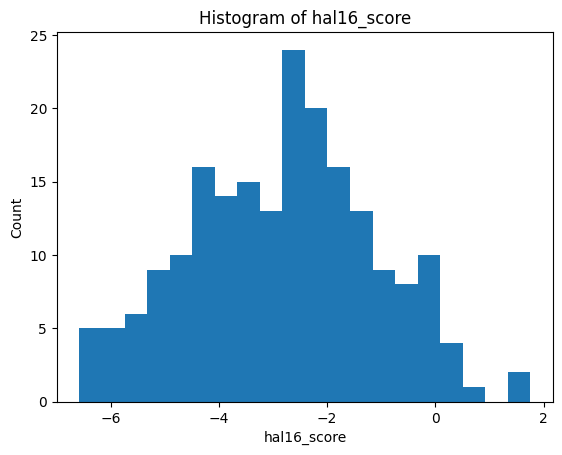

In [304]:
import matplotlib.pyplot as plt

plt.hist(output_dfs[0]["hal16_score"], bins=20)
plt.xlabel("hal16_score")
plt.ylabel("Count")
plt.title("Histogram of hal16_score")
plt.show()

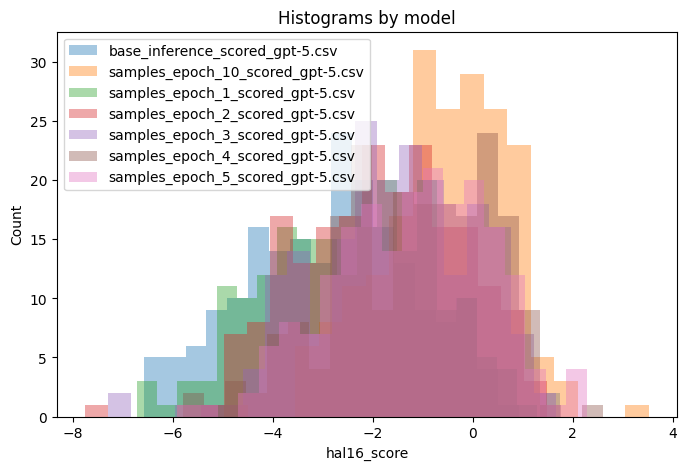

In [305]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for i in range(len(output_dfs)):
    subset = output_dfs[i]["hal16_score"]
    plt.hist(subset, bins=20, alpha=0.4, label=output_files[i])

plt.xlabel("hal16_score")
plt.ylabel("Count")
plt.title("Histograms by model")
plt.legend()
plt.show()


In [306]:
!pip install -q seaborn

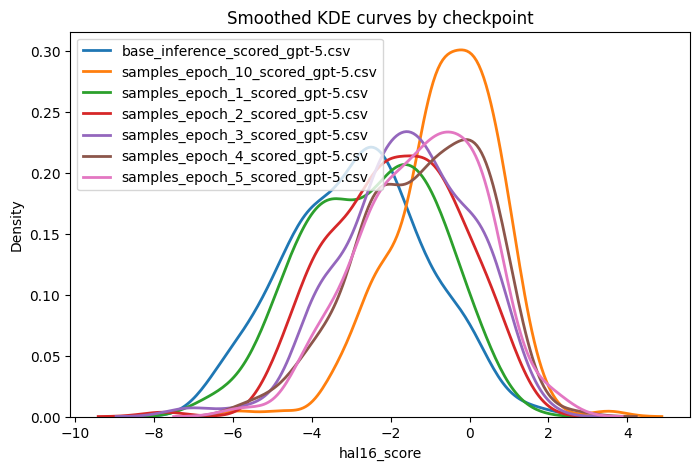

In [307]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

for i in range(len(output_dfs)):
    subset = output_dfs[i]["hal16_score"]
    sns.kdeplot(subset, fill=False, linewidth=2, label=output_files[i])

plt.xlabel("hal16_score")
plt.ylabel("Density")
plt.title("Smoothed KDE curves by checkpoint")
plt.legend()
plt.show()


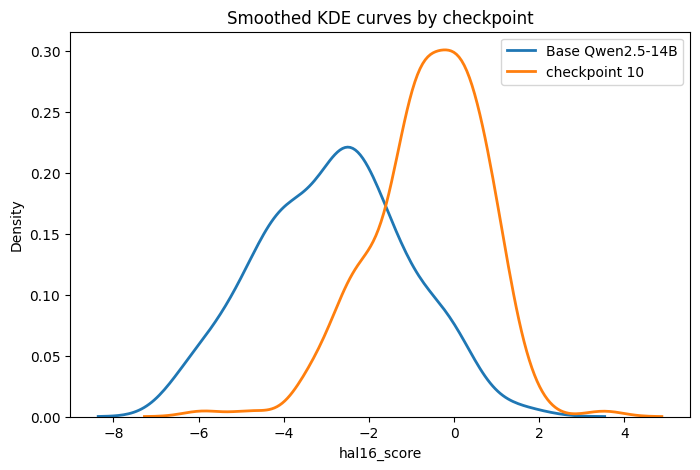

In [308]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

subset = output_dfs[0]["hal16_score"]
sns.kdeplot(subset, fill=False, linewidth=2, label=f"Base Qwen2.5-14B")
subset = output_dfs[1]["hal16_score"]
sns.kdeplot(subset, fill=False, linewidth=2, label=f"checkpoint 10")

plt.xlabel("hal16_score")
plt.ylabel("Density")
plt.title("Smoothed KDE curves by checkpoint")
plt.legend()
plt.show()

In [274]:
print("Base: ", output_dfs[0]["hal16_score"].mean(), output_dfs[0]["hal16_score"].std())
print("Mean, STD, Diff")
for i in range(1,len(output_dfs)):
    print("Epoch {}: {} {} {}".format(i, 
                                      np.round(output_dfs[i]["hal16_score"].mean(), 3), 
                                      np.round(output_dfs[i]["hal16_score"].std(), 3), 
                                      np.round(output_dfs[i]["hal16_score"].mean() - output_dfs[0]["hal16_score"].mean(), 3)))

Base:  -2.8387515284189844 1.714334219608961
Mean, STD, Diff
Epoch 1: -0.603 1.307 2.236
Epoch 2: -2.49 1.67 0.349
Epoch 3: -1.858 1.602 0.98
Epoch 4: -1.606 1.613 1.233
Epoch 5: -1.201 1.57 1.638
Epoch 6: -1.216 1.529 1.623


## Statistical test

In [189]:
from scipy.stats import ttest_rel

scores_5 = output_dfs[5]["hal16_score"]
scores_0 = output_dfs[0]["hal16_score"]

t_stat, p_val = ttest_rel(scores_5, scores_0)

print("t =", t_stat)
print("p =", p_val)

t = 10.114897804553122
p = 1.138347383405046e-19


In [190]:
from scipy.stats import ttest_rel

t_stat, p_val_two_sided = ttest_rel(scores_5, scores_0)

# convert to one-sided p-value
p_val_one_sided = p_val_two_sided / 2 if t_stat > 0 else 1.0

print("t =", t_stat)
print("one-sided p =", p_val_one_sided)

t = 10.114897804553122
one-sided p = 5.69173691702523e-20


## Manual Observation

In [287]:
## Favorite examples: 1, 2, 
chosen_ids = []

In [296]:
ground_truth = []
judge_choice = []

In [ ]:
import random

for _ in range(6):
    i = random.randint(0,len(output_dfs[0]))
    while i in chosen_ids:
        i = random.randint(0,len(output_dfs[0]))
    choice = random.choice([0, 1])
    ground_truth.append(choice)
    
    print("Prompt:", output_dfs[0]["prompt"][i], "\n")
    print()
    
    # print("Base Qwen2.5-14B", output_dfs[0]["dialogue_id"][i])
    if choice:
        print("Dialogue 0")
        # print("Score:", output_dfs[5]["hal16_score"][i], "\n")
        print(output_dfs[0]["dialogue"][i])
    
        print("\n\nDialogue 1")
        # print("Score:", output_dfs[0]["hal16_score"][i], "\n")
        print(output_dfs[1]["dialogue"][i])
    
    else:
        print("Dialogue 0")
        # print("Score:", output_dfs[0]["hal16_score"][i], "\n")
        print(output_dfs[1]["dialogue"][i])
        
        # print("\n--------\nCheckpoint 5", output_dfs[5]["dialogue_id"][i])
        print("\n\nDialogue 1")
        # print("Score:", output_dfs[5]["hal16_score"][i], "\n")
        print(output_dfs[0]["dialogue"][i])
    
    user_input = int(input("\n\nEnter which is better:"))
    if user_input not in [0,1,-1,2]:
        break
    judge_choice.append(user_input)

Prompt: Generate a full conversation of the following person at the doctor's visit.
Give them a unique personality based on their biography. Follow a linguistic style suitable for the person. Vary the statement lengths to make it natural.
Don't say anything else.

<input_data>
Biography: Tyler Grayson is a 20-year-old college student born and raised in Colorado. Despite not having a completed degree, Tyler is unusually self-assured about his future, often reminding others of his extensive travels and unique experiences. He devotes much of his personal time to researching exotic travel destinations, planning the trendiest itineraries, and then documenting the adventures online, always striving for the perfect shot for his highly-curated Instagram feed. Tyler relishes trying out the latest restaurants and is quick to drop local slang from his recent trips, enjoying the attention this brings. Social by nature, he relishes hosting gatherings in his small but stylish apartment, where being 



Enter which is better: 0


Prompt: Generate a full conversation of the following person at the doctor's visit.
Give them a unique personality based on their biography. Follow a linguistic style suitable for the person. Vary the statement lengths to make it natural.
Don't say anything else.

<input_data>
Biography: Gerald O'Malley, a 76-year-old retired social worker, was born and raised in a small town in New Mexico. The grandson of Irish immigrants, Gerald grew up with stories of perseverance and social advocacy at the dinner table, which inspired his lifelong commitment to community service. He graduated from high school in the late 1960s and went on to dedicate over four decades to serving vulnerable populations as a social worker. Now retired, Gerald lives with his wife, Helen, in a quiet neighborhood, without children at home but frequently visited by neighbors and friends. Known for his expressive hand gestures and animated storytelling, Gerald volunteers at the local food bank and stays active in liberal 



Enter which is better: 0


Prompt: Generate a full conversation of the following person at the doctor's visit.
Give them a unique personality based on their biography. Follow a linguistic style suitable for the person. Vary the statement lengths to make it natural.
Don't say anything else.

<input_data>
Biography: Yvonne Turner, 58, has spent most of her life in St. Louis. A proud Black woman living alone in a modest apartment, she finds solace in the hum and click of old radios and VCRs—her happiest hours are spent bringing obsolete gadgets back to life. Yvonne’s home is cozy if cluttered, filled with thrift store treasures, church bulletins pinned on the fridge, and a shelf dedicated to her beloved gospel cassettes. Despite having started college, life tugged her elsewhere before she could finish, and money’s often tight—especially now that she’s on a fixed income. Her warmth draws people in at Sunday potlucks, where she’s known for a big laugh, gentle advice, and a willingness to listen. While Yvonne’s friend



Enter which is better: 0


Prompt: Generate a full conversation of the following person at the doctor's visit.
Give them a unique personality based on their biography. Follow a linguistic style suitable for the person. Vary the statement lengths to make it natural.
Don't say anything else.

<input_data>
Biography: Malik Thompson is a 21-year-old born and raised in Newark, New Jersey. He currently works as an employee for a fast-growing e-commerce company, focused on the inspection and quality control of consumer electronics before items are shipped out. A self-proclaimed gadget nerd, Malik enjoys tinkering with new technology at home and keeps up with the latest trends in tech through podcasts and YouTube. While juggling his job, Malik is also working toward an associate's degree at a local community college, taking courses in business and information systems—though balancing work, study, and life has sometimes slowed his academic progress.

Community plays a big role in Malik’s life: he regularly volunteers at 

In [291]:
print(ground_truth)
print(judge_choice)

[0]
[]


In [ ]:
chosen_ids

In [ ]:
2

In [284]:
import numpy as np

correct = np.array(choices) == np.array(which_is_better)
print(correct)

[False False  True  True  True  True False False False False  True False
  True False  True  True]


In [285]:
np.sum(correct*1)/len(correct)

np.float64(0.5)

In [240]:
## Differences are not obvious or visible

In [ ]:
import random

for _ in range(6):
    i = random.randint(0,len(output_dfs[0]))
    while i in chosen_ids:
        i = random.randint(0,len(output_dfs[0]))
    choice = random.choice([0, 1])
    ground_truth.append(choice)
    
    print("Prompt:", output_dfs[0]["prompt"][i], "\n")
    print()
    
    # print("Base Qwen2.5-14B", output_dfs[0]["dialogue_id"][i])
    if choice:
        print("Dialogue 0")
        # print("Score:", output_dfs[5]["hal16_score"][i], "\n")
        print(output_dfs[0]["dialogue"][i])
    
        print("\n\nDialogue 1")
        # print("Score:", output_dfs[0]["hal16_score"][i], "\n")
        print(output_dfs[1]["dialogue"][i])
    
    else:
        print("Dialogue 0")
        # print("Score:", output_dfs[0]["hal16_score"][i], "\n")
        print(output_dfs[1]["dialogue"][i])
        
        # print("\n--------\nCheckpoint 5", output_dfs[5]["dialogue_id"][i])
        print("\n\nDialogue 1")
        # print("Score:", output_dfs[5]["hal16_score"][i], "\n")
        print(output_dfs[0]["dialogue"][i])
    
    user_input = int(input("\n\nEnter which is better:"))
    if user_input not in [0,1,-1,2]:
        break
    judge_choice.append(user_input)

### Examples

In [312]:
output_dfs[0]['likert_evaluation']

0      [5, 1, 1, 1, 1, 5, 5, 1, 1, 3, 5, 2, 3, 3, 1, 4]
1      [3, 1, 1, 1, 1, 5, 5, 5, 3, 5, 5, 2, 3, 4, 1, 5]
2      [5, 1, 1, 1, 1, 5, 5, 1, 1, 1, 5, 3, 4, 3, 2, 5]
3      [5, 1, 1, 1, 1, 5, 5, 1, 1, 1, 5, 4, 5, 4, 1, 5]
4      [3, 1, 1, 1, 1, 5, 5, 5, 1, 4, 5, 1, 4, 5, 1, 5]
                             ...                       
195    [3, 1, 1, 1, 1, 5, 5, 4, 1, 3, 5, 1, 3, 4, 1, 5]
196    [3, 1, 1, 1, 1, 5, 5, 1, 1, 1, 5, 1, 1, 3, 1, 4]
197    [5, 1, 1, 1, 1, 5, 5, 5, 2, 3, 5, 2, 1, 4, 1, 3]
198    [2, 1, 1, 1, 1, 5, 5, 4, 1, 1, 5, 1, 3, 5, 1, 5]
199    [2, 1, 1, 1, 1, 5, 5, 5, 1, 4, 4, 1, 4, 4, 1, 5]
Name: likert_evaluation, Length: 200, dtype: object

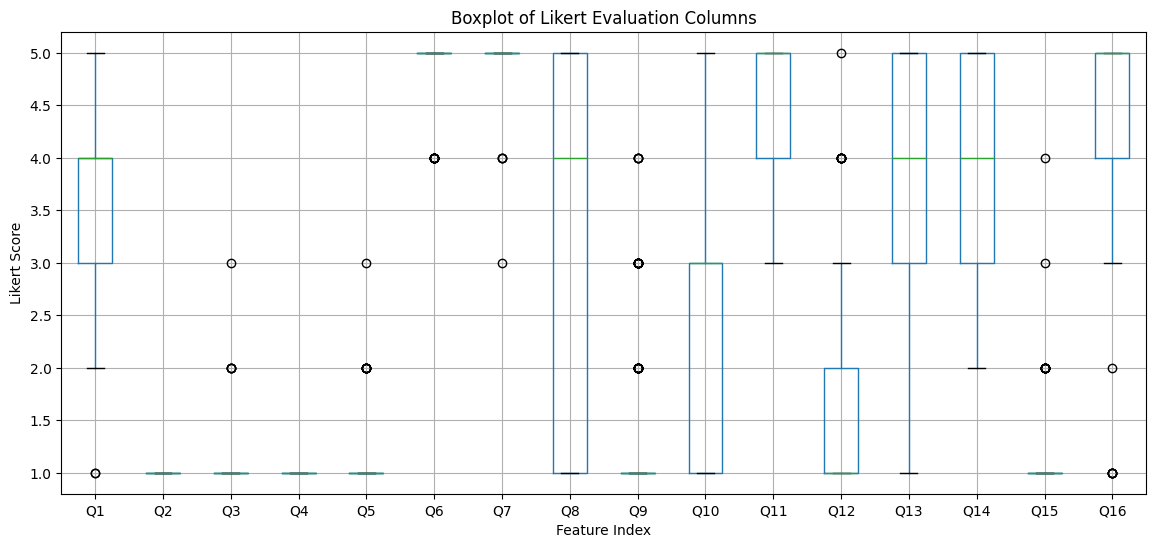

In [314]:
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Convert the column of string lists into real Python lists
df = output_dfs[0].copy()
df["likert_list"] = df["likert_evaluation"].apply(ast.literal_eval)

# Expand into 16 columns
likert_matrix = pd.DataFrame(df["likert_list"].tolist())
likert_matrix.columns = [f"Q{i}" for i in range(1, len(likert_matrix.columns)+1)]

# Plot boxplots
plt.figure(figsize=(14, 6))
likert_matrix.boxplot()
plt.title("Boxplot of Likert Evaluation Columns")
plt.xlabel("Feature Index")
plt.ylabel("Likert Score")
plt.show()


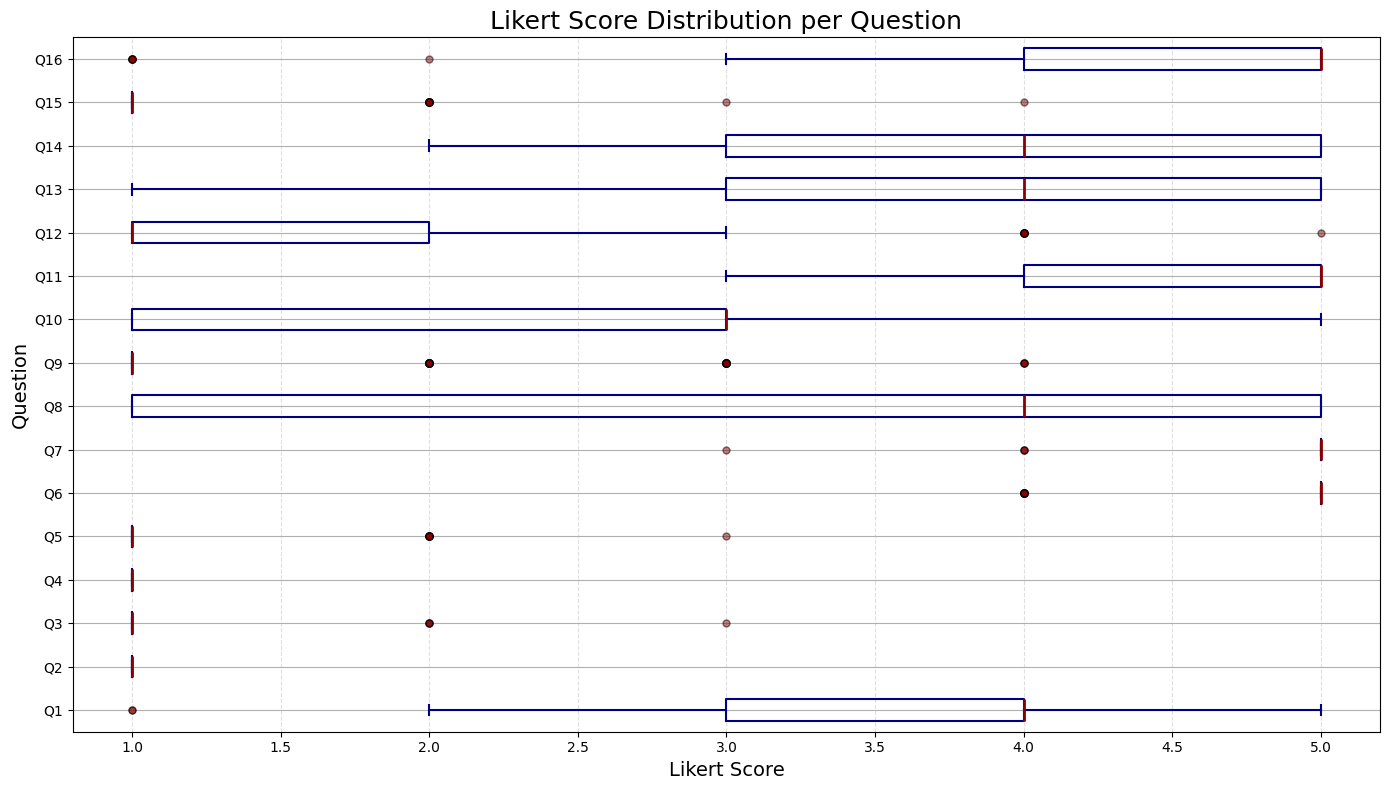

In [316]:
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Convert string lists → real lists
df = output_dfs[0].copy()
df["likert_list"] = df["likert_evaluation"].apply(ast.literal_eval)

# Expand lists into columns
likert_matrix = pd.DataFrame(df["likert_list"].tolist())
likert_matrix.columns = [f"Q{i}" for i in range(1, likert_matrix.shape[1]+1)]

# Plot
plt.figure(figsize=(14, 8))

boxprops = dict(linewidth=1.5, color="navy")
medianprops = dict(linewidth=2, color="darkred")
whiskerprops = dict(linewidth=1.5, color="navy")
capprops = dict(linewidth=1.5, color="navy")
flierprops = dict(marker="o", markersize=5, markerfacecolor="darkred", alpha=0.5)

likert_matrix.boxplot(
    vert=False,
    boxprops=boxprops,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    flierprops=flierprops
)

plt.title("Likert Score Distribution per Question", fontsize=18)
plt.xlabel("Likert Score", fontsize=14)
plt.ylabel("Question", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()
